#  Problem set 5
Laszlo Tetenyi

I asked Juan for help as my vanilla code (one to one implementation of my Python code) was running for more than a minute

In [4]:
using PyPlot
addprocs(4) # The max number of processors on my PC

@everywhere begin
    type AR1 #Define the AR1 type as in the lecture
        alpha::Float64 #linear term
        beta::Float64  #constant term
        sigma::Float64 # standard deviation of the error
        n::Int # Sample size
        n_break::Int # Number of breakpoint in n
        simusize::Int # Number of simulations
    end


    # Iteration as in the lecture notes
    iter(ar1::AR1, x) = ar1.beta + ar1.alpha*x + ar1.sigma*randn()

    function AR1coeff(ar1::AR1)
        average = 0.0
        for i=1:ar1.simusize
            x = Array(Float64, ar1.n)
            x[1] = ar1.beta/(1-ar1.alpha)
            for t = 2:ar1.n
                x[t] = iter(ar1, x[t-1])
            end
            cons=ones(x[1:(end-1)])
            x_prev=x[1:(end-1)]
            X = hcat(cons,x_prev)
            Y = x[2:end]
            coeff=  \(*(X',X),*(X',Y))
            average += coeff[2]
        end
        return average/ar1.simusize
    end
end

In [5]:
function AR1bias(alpha_grid::Array{Float64}, n_grid::Vector{Int})
    bias = SharedArray(Float64,(length(n_grid), length(alpha_grid)))
    # Just run the loop for each alpha and each n
    # It seems it does not make a big difference to simulate the data for different n or to do it only once
    for i in eachindex(alpha_grid)
        alpha = alpha_grid[i]
        @sync @parallel for j in eachindex(n_grid) 
            n = n_grid[j]
            ar1 = AR1(alpha, 0.0, 1.0, n,10, 10000)
            alphahat = AR1coeff(ar1)
            bias[j, i] = alphahat - alpha
        end
    end
    return bias
end

AR1bias (generic function with 1 method)

In [11]:
# Define the grid
alpha_grid = collect(linspace(0.5,0.9,5))
n_grid = convert(Array{Int},collect(linspace(50,500,10)))

# A bit slow at the first run
@time bias = AR1bias(alpha_grid,n_grid)

10x5 SharedArray{Float64,2}:
 -0.0523354   -0.0589292   -0.0687822   -0.0760416   -0.0890018 
 -0.0271492   -0.0287245   -0.0324381   -0.0353968   -0.0425294 
 -0.0168444   -0.0183811   -0.0202779   -0.0230886   -0.027496  
 -0.0128722   -0.0143177   -0.0160919   -0.0178516   -0.0200685 
 -0.00994075  -0.0112966   -0.0129853   -0.0135978   -0.015813  
 -0.00875593  -0.0087221   -0.0102397   -0.0118011   -0.0126056 
 -0.00679332  -0.0077812   -0.00886851  -0.00960537  -0.0108225 
 -0.0065109   -0.0068677   -0.00804546  -0.00859502  -0.00916056
 -0.00556917  -0.00661503  -0.0063797   -0.00742406  -0.00853407
 -0.00496362  -0.00589689  -0.00617314  -0.00699732  -0.00747405

 4.327119 seconds (83.55 k allocations: 6.215 MB)


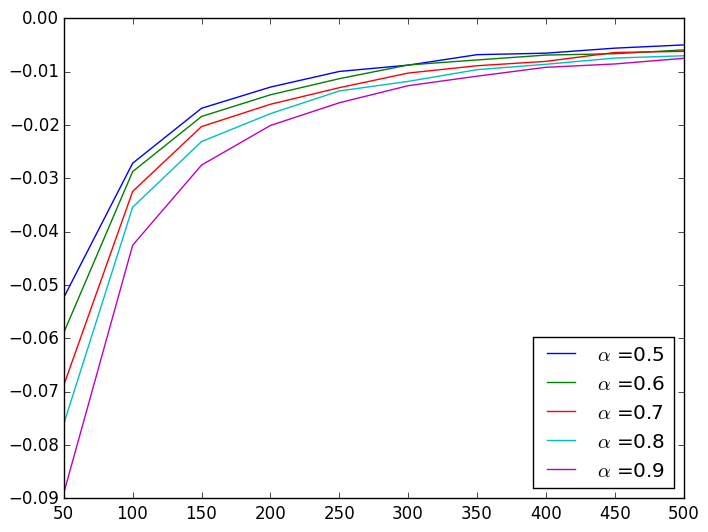

PyObject <matplotlib.legend.Legend object at 0x00000000220D2748>

In [12]:
fig, ax = subplots()
for (i, ai) in enumerate(alpha_grid)
    ax[:plot](n_grid, bias[:,i],label=L"$\alpha$ =""$ai")
end
ax[:legend](loc=4)